In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install torchsummary

In [4]:
import torch.nn as nn

class Net_LN(nn.Module):
    def __init__(self):
        super(Net_LN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=(3, 3), bias=False),
            nn.LayerNorm([6, 30, 30]),
            nn.ReLU(),
            nn.Conv2d(6, 6, kernel_size=(3, 3), bias=False),
            nn.LayerNorm([6, 28, 28]),
            nn.ReLU(),
            nn.Conv2d(6, 6, kernel_size=(1, 1), bias=False),
            nn.LayerNorm([6,28,28]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 6, kernel_size=(3, 3), bias=False),
            nn.LayerNorm([6,12,12]),
            nn.ReLU(),
            nn.Conv2d(6, 8, kernel_size=(3, 3), bias=False, padding = 1),
            nn.LayerNorm([8,12,12]),
            nn.ReLU(),
            nn.Conv2d(8, 12, kernel_size=(3, 3), bias=False, padding = 1),
            nn.LayerNorm([12,12,12]),
            nn.ReLU(),
            nn.Conv2d(12, 12, kernel_size=(1, 1), bias=False),
            nn.LayerNorm([12,12,12]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 12, kernel_size=(3, 3), bias=False, padding = 1),
            nn.LayerNorm([12,6,6]),
            nn.ReLU(),
            nn.Conv2d(12, 12, kernel_size=(3, 3), bias=False, padding = 1),
            nn.LayerNorm([12,6,6]),
            nn.ReLU(),
            nn.Conv2d(12, 12, kernel_size=(3, 3), bias=False, padding = 1),
            nn.LayerNorm([12,6,6]),
            nn.ReLU(),
            nn.Sequential(nn.AvgPool2d(kernel_size=6)),
            nn.Conv2d(12, 10, kernel_size=(1, 1), bias=False)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net_LN().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             162
         LayerNorm-2            [-1, 6, 30, 30]          10,800
              ReLU-3            [-1, 6, 30, 30]               0
            Conv2d-4            [-1, 6, 28, 28]             324
         LayerNorm-5            [-1, 6, 28, 28]           9,408
              ReLU-6            [-1, 6, 28, 28]               0
            Conv2d-7            [-1, 6, 28, 28]              36
         LayerNorm-8            [-1, 6, 28, 28]           9,408
              ReLU-9            [-1, 6, 28, 28]               0
        MaxPool2d-10            [-1, 6, 14, 14]               0
           Conv2d-11            [-1, 6, 12, 12]             324
        LayerNorm-12            [-1, 6, 12, 12]           1,728
             ReLU-13            [-1, 6, 12, 12]               0
           Conv2d-14            [-1, 8,

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((32, 32)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((32, 32)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


In [7]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 100868058.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [9]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

dataiter = iter(train_loader)
images, labels = next(dataiter)

Files already downloaded and verified
Files already downloaded and verified


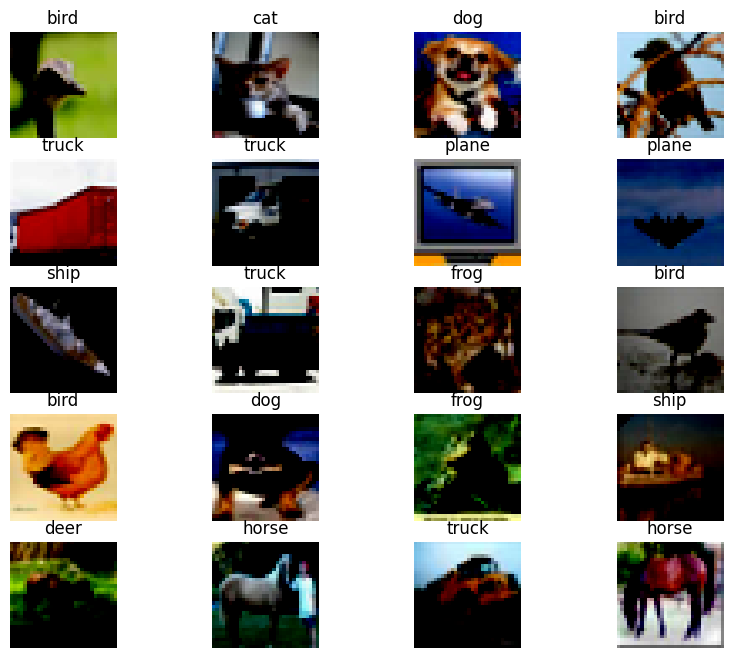

In [10]:
figure = plt.figure(figsize=(10,8))
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(5, 4, index)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1, 2, 0)))
    plt.title(classes[labels[index].item()])


In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.90)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Epoch 1


Loss=1.9849956035614014 Batch_id=390 Accuracy=20.97: 100%|██████████| 391/391 [00:25<00:00, 15.37it/s]



Test set: Average loss: 1.9201, Accuracy: 2836/10000 (28.36%)

Epoch 2


Loss=1.9071085453033447 Batch_id=390 Accuracy=31.27: 100%|██████████| 391/391 [00:16<00:00, 24.44it/s]



Test set: Average loss: 1.8134, Accuracy: 3269/10000 (32.69%)

Epoch 3


Loss=1.8716459274291992 Batch_id=390 Accuracy=34.86: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s]



Test set: Average loss: 1.7200, Accuracy: 3609/10000 (36.09%)

Epoch 4


Loss=1.7670997381210327 Batch_id=390 Accuracy=37.01: 100%|██████████| 391/391 [00:15<00:00, 25.23it/s]



Test set: Average loss: 1.6695, Accuracy: 3924/10000 (39.24%)

Epoch 5


Loss=1.6380523443222046 Batch_id=390 Accuracy=40.32: 100%|██████████| 391/391 [00:16<00:00, 24.29it/s]



Test set: Average loss: 1.5848, Accuracy: 4163/10000 (41.63%)

Epoch 6


Loss=1.6125354766845703 Batch_id=390 Accuracy=44.27: 100%|██████████| 391/391 [00:16<00:00, 24.25it/s]



Test set: Average loss: 1.5190, Accuracy: 4437/10000 (44.37%)

Epoch 7


Loss=1.4699625968933105 Batch_id=390 Accuracy=45.00: 100%|██████████| 391/391 [00:16<00:00, 23.14it/s]



Test set: Average loss: 1.5096, Accuracy: 4468/10000 (44.68%)

Epoch 8


Loss=1.4772942066192627 Batch_id=390 Accuracy=45.67: 100%|██████████| 391/391 [00:15<00:00, 24.63it/s]



Test set: Average loss: 1.4925, Accuracy: 4516/10000 (45.16%)

Epoch 9


Loss=1.5121519565582275 Batch_id=390 Accuracy=46.35: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]



Test set: Average loss: 1.4866, Accuracy: 4503/10000 (45.03%)

Epoch 10


Loss=1.3423035144805908 Batch_id=390 Accuracy=46.71: 100%|██████████| 391/391 [00:16<00:00, 24.28it/s]



Test set: Average loss: 1.4714, Accuracy: 4576/10000 (45.76%)

Epoch 11


Loss=1.3985722064971924 Batch_id=390 Accuracy=47.57: 100%|██████████| 391/391 [00:15<00:00, 24.50it/s]



Test set: Average loss: 1.4640, Accuracy: 4606/10000 (46.06%)

Epoch 12


Loss=1.3132745027542114 Batch_id=390 Accuracy=47.72: 100%|██████████| 391/391 [00:16<00:00, 24.12it/s]



Test set: Average loss: 1.4637, Accuracy: 4613/10000 (46.13%)

Epoch 13


Loss=1.644892930984497 Batch_id=390 Accuracy=47.74: 100%|██████████| 391/391 [00:16<00:00, 24.35it/s]



Test set: Average loss: 1.4620, Accuracy: 4611/10000 (46.11%)

Epoch 14


Loss=1.4857591390609741 Batch_id=390 Accuracy=47.80: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s]



Test set: Average loss: 1.4611, Accuracy: 4641/10000 (46.41%)

Epoch 15


Loss=1.3930221796035767 Batch_id=390 Accuracy=47.87: 100%|██████████| 391/391 [00:16<00:00, 24.16it/s]



Test set: Average loss: 1.4595, Accuracy: 4618/10000 (46.18%)

Epoch 16


Loss=1.3436466455459595 Batch_id=390 Accuracy=47.97: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s]



Test set: Average loss: 1.4591, Accuracy: 4623/10000 (46.23%)

Epoch 17


Loss=1.511040449142456 Batch_id=390 Accuracy=48.02: 100%|██████████| 391/391 [00:16<00:00, 24.05it/s]



Test set: Average loss: 1.4589, Accuracy: 4629/10000 (46.29%)

Epoch 18


Loss=1.3460862636566162 Batch_id=390 Accuracy=47.97: 100%|██████████| 391/391 [00:16<00:00, 23.15it/s]



Test set: Average loss: 1.4587, Accuracy: 4631/10000 (46.31%)

Epoch 19


Loss=1.464496374130249 Batch_id=390 Accuracy=47.95: 100%|██████████| 391/391 [00:16<00:00, 23.64it/s]



Test set: Average loss: 1.4586, Accuracy: 4632/10000 (46.32%)

Epoch 20


Loss=1.5869345664978027 Batch_id=390 Accuracy=47.96: 100%|██████████| 391/391 [00:16<00:00, 24.15it/s]



Test set: Average loss: 1.4585, Accuracy: 4636/10000 (46.36%)



Text(0.5, 1.0, 'Test Accuracy')

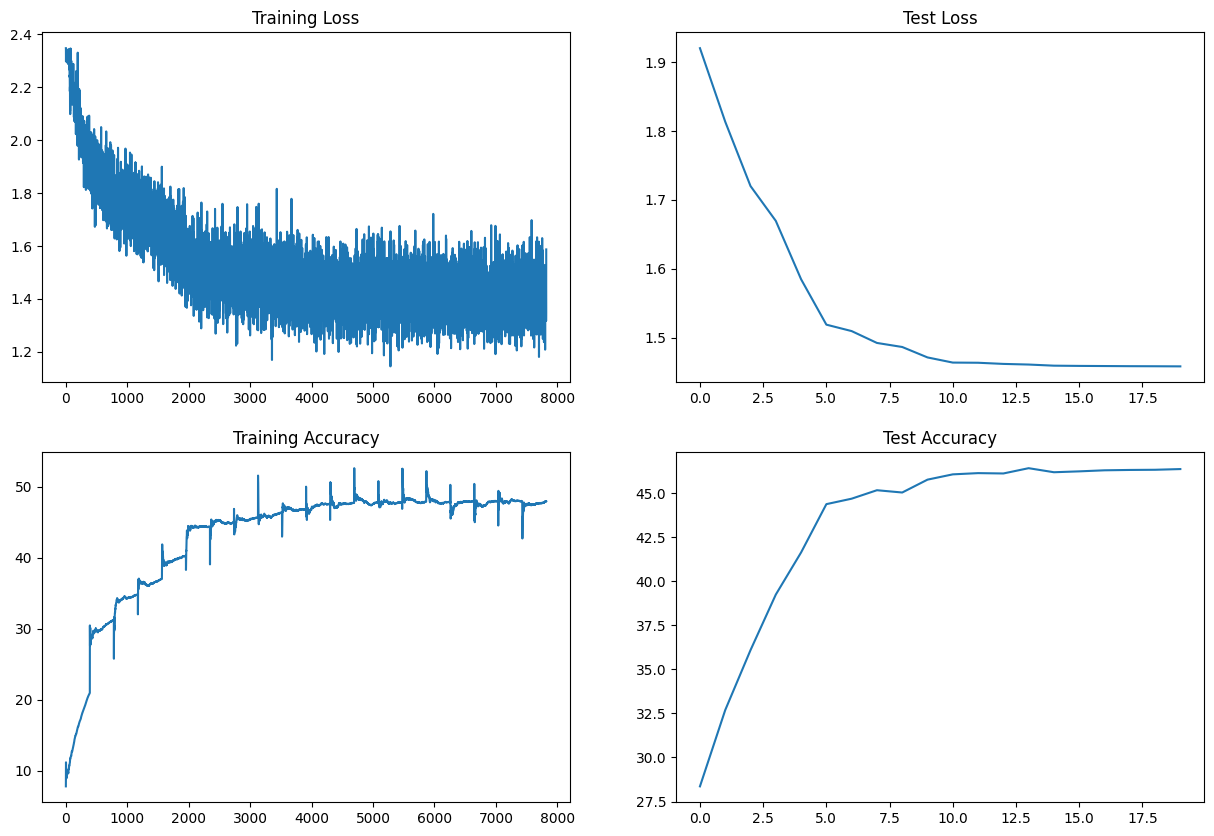

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.tensor(train_losses).cpu().detach().numpy())
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [14]:
error_images = []
error_target = []
error_predicted = []
count = 0

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  for i in range (0, 127):
    if (pred[i].cpu().numpy()[0] != target[i].cpu().numpy()):
      error_images.append(data[i])
      error_target.append(target[i].cpu().numpy())
      error_predicted.append(pred[i].cpu().numpy()[0])

      count = count + 1

      if count > 10:
        break

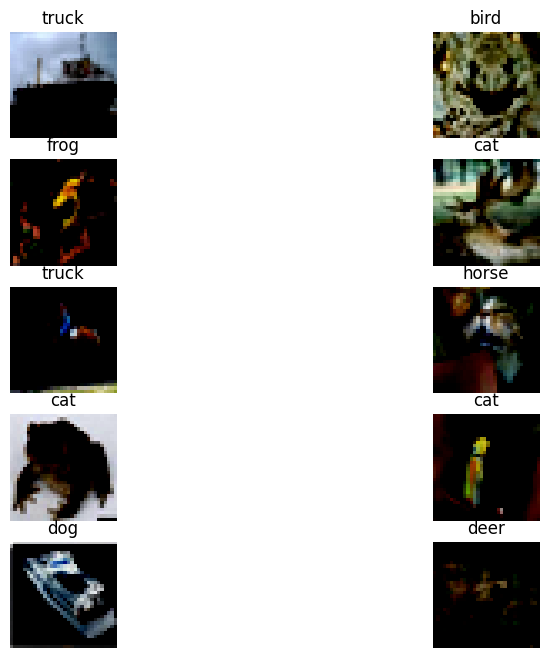

In [15]:
figure = plt.figure(figsize=(10, 8))
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(5, 2, index)
    plt.axis('off')
    plt.imshow(np.transpose(error_images[index].cpu().numpy(), (1, 2, 0)))
    plt.title(classes[error_predicted[index].item()])
